# Úkol č. 3 - shlukování

  * **Deadline je do 28. 12. 2022, 23:59:59**, pokud odevzdáte úkol do 4. 1. 2023, 23:59:59, budete penalizování -4 body, pozdější odevzdání je bez bodu.
  * V rámci tohoto úkolu se musíte vypořádat s problematikou shlukování.
    
> **Úkoly jsou zadány tak, aby Vám daly prostor pro invenci. Vymyslet _jak přesně_ budete úkol řešit, je důležitou součástí zadání a originalita či nápaditost bude také hodnocena!**

Využívejte buňky typu `Markdown` k vysvětlování Vašeho postupu. Za nepřehlednost budeme strhávat body.

## Zdroj dat

  * Zdrojem dat je soubor `CC GENERAL.csv` (originál zde: https://www.kaggle.com/datasets/arjunbhasin2013/ccdata).
  * Popis datasetu najdete v souboru `data_description.txt`.

## Pokyny k vypracování

**Body zadání**, za jejichž (poctivé) vypracování získáte **16 bodů**:
  * Proveďte základní průzkum dat a svá pozorování diskutujte. Na jeho základě adekvátně reagujte na problematické věci v datech (chybějící hodnoty, atd.) a vysvětlete motivaci k provedeným krokům.
  * Vytvořte **vlastní implementaci** algoritmu KMeans.
  * Pomocí této vlastní implementace proveďte shlukování.
  * Zopakujte shlukování s implementací `sklearn.cluster.KMeans`. Pokuste se sladit hyperparametry tak, abyste dostali stejné výsledky. Pokud se Vám to nepovede, diskutujte proč.
  * Pokuste se odhadnout vhodný počet shluků (např. metodou lokte).
  * Proveďte také aglomerativní hierarchické shlukování (použijte existující implementaci) a nakreslete dendrogram (resp. alespoň jeho vhodnou horní část).
  * Zopakujte předchozí kroky a při tom experimentujte s různými hodnotami hyperparametrů a také se standardizací/normalizací dat.
    * Kvalitu vytvořených shluků můžete analyzovat pomocí metody Silhouette (https://en.wikipedia.org/wiki/Silhouette_(clustering)).
  * Cílem je vybrat shlukování, které Vám přijde nejlepší (můžete přihlédnout k následujícímu bodu). Popište, proč jste ho vybrali.
  * Na tomto vybraném shlukování se pokuste interpretovat výsledné shluky.
    * Snažte se identifikovat a popsat typy uživatelů kreditních karet podle Vámi zvolených vybraných kritérií. Můžete přitom koukat například na BALANCE, PURCHASES, CASH_ADVANCE, PAYMENTS, atd.
  

## Poznámky k odevzdání

  * Řiďte se pokyny ze stránky https://courses.fit.cvut.cz/BI-ML1/homeworks/index.html.
  * Opravující Vám ve výjimečných případech může umožnit úkol dodělat či opravit a získat tak další body. První verze je ale stěžejní a má hlavní vliv na hodnocení.

# Moje vypracování:

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import matplotlib

from scipy.cluster.hierarchy import linkage
from scipy.cluster.hierarchy import dendrogram
from scipy.cluster.hierarchy import fcluster
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import cophenet
from scipy.spatial.distance import pdist
from sklearn.cluster import KMeans

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker # Mřížka grafů
import seaborn as sb

import random
import math

## Průzkum dat

In [2]:
df = pd.read_csv("CC GENERAL.csv")

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8950 entries, 0 to 8949
Data columns (total 18 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   CUST_ID                           8950 non-null   object 
 1   BALANCE                           8950 non-null   float64
 2   BALANCE_FREQUENCY                 8950 non-null   float64
 3   PURCHASES                         8950 non-null   float64
 4   ONEOFF_PURCHASES                  8950 non-null   float64
 5   INSTALLMENTS_PURCHASES            8950 non-null   float64
 6   CASH_ADVANCE                      8950 non-null   float64
 7   PURCHASES_FREQUENCY               8950 non-null   float64
 8   ONEOFF_PURCHASES_FREQUENCY        8950 non-null   float64
 9   PURCHASES_INSTALLMENTS_FREQUENCY  8950 non-null   float64
 10  CASH_ADVANCE_FREQUENCY            8950 non-null   float64
 11  CASH_ADVANCE_TRX                  8950 non-null   int64  
 12  PURCHA

In [4]:
df.describe()

,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE
count,8950.000000,8950.000000,8950.000000,8950.000000,8950.000000,8950.000000,8950.000000,8950.000000,8950.000000,8950.000000,8950.000000,8950.000000,8949.000000,8950.000000,8637.000000,8950.000000,8950.000000
mean,1564.474828,0.877271,1003.204834,592.437371,411.067645,978.871112,0.490351,0.202458,0.364437,0.135144,3.248827,14.709832,4494.449450,1733.143852,864.206542,0.153715,11.517318
std,2081.531879,0.236904,2136.634782,1659.887917,904.338115,2097.163877,0.401371,0.298336,0.397448,0.200121,6.824647,24.857649,3638.815725,2895.063757,2372.446607,0.292499,1.338331
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,50.000000,0.000000,0.019163,0.000000,6.000000
25%,128.281915,0.888889,39.635000,0.000000,0.000000,0.000000,0.083333,0.000000,0.000000,0.000000,0.000000,1.000000,1600.000000,383.276166,169.123707,0.000000,12.000000
50%,873.385231,1.000000,361.280000,38.000000,89.000000,0.000000,0.500000,0.083333,0.166667,0.000000,0.000000,7.000000,3000.000000,856.901546,312.343947,0.000000,12.000000
75%,2054.140036,1.000000,1110.130000,577.405000,468.637500,1113.821139,0.916667,0.300000,0.750000,0.222222,4.000000,17.000000,6500.000000,1901.134317,825.485459,0.142857,12.000000
max,19043.138560,1.000000,49039.570000,40761.250000,22500.000000,47137.211760,1.000000,1.000000,1.000000,1.500000,123.000000,358.000000,30000.000000,50721.483360,76406.207520,1.000000,12.000000


In [5]:
for x in df.columns:
    print(x,":")
    print("Datový typ:", df[x].dtype)
    print("Počet chybějících záznamů:", df[x].isnull().sum())
    print("Počet unikátních hodnot:", df[x].nunique())
    T = df[df[x].notnull()][x].sort_values().unique()
    print("Rozsah hodnot:", T[0], "-", T[-1])
    print("Počet unikátních hodnot:", df[x].nunique())
    print("============================")

CUST_ID :
Datový typ: object
Počet chybějících záznamů: 0
Počet unikátních hodnot: 8950
Rozsah hodnot: C10001 - C19190
Počet unikátních hodnot: 8950
BALANCE :
Datový typ: float64
Počet chybějících záznamů: 0
Počet unikátních hodnot: 8871
Rozsah hodnot: 0.0 - 19043.13856
Počet unikátních hodnot: 8871
BALANCE_FREQUENCY :
Datový typ: float64
Počet chybějících záznamů: 0
Počet unikátních hodnot: 43
Rozsah hodnot: 0.0 - 1.0
Počet unikátních hodnot: 43
PURCHASES :
Datový typ: float64
Počet chybějících záznamů: 0
Počet unikátních hodnot: 6203
Rozsah hodnot: 0.0 - 49039.57
Počet unikátních hodnot: 6203
ONEOFF_PURCHASES :
Datový typ: float64
Počet chybějících záznamů: 0
Počet unikátních hodnot: 4014
Rozsah hodnot: 0.0 - 40761.25
Počet unikátních hodnot: 4014
INSTALLMENTS_PURCHASES :
Datový typ: float64
Počet chybějících záznamů: 0
Počet unikátních hodnot: 4452
Rozsah hodnot: 0.0 - 22500.0
Počet unikátních hodnot: 4452
CASH_ADVANCE :
Datový typ: float64
Počet chybějících záznamů: 0
Počet unikátn

* Příznak CUST_ID je pouze identifikátor a nemá pro tuto úlohu žádnou hodnotu, proto ho odeberu

In [6]:
df.drop("CUST_ID", axis=1, inplace=True)

* 300 záznamů obsahuje nulové hodnoty a takové odeberu, protože mi jich ještě zbyde v datasetu dost

In [7]:
df.dropna(inplace=True)

## Vlastní implementace K-Means

In [8]:
k = 2 # hyperparametr

In [9]:
# Eukleid distance
def distance(vector1, vector2):
    sum = 0
    for j in range(len(df.columns)):
        sum += (vector1[j] - vector2[j]) ** 2

    return math.sqrt(sum)
#-------------------------------------------------#
def my_kmeans(k, df):
    # první náhodná inicializace středových bodů
    mids = [ df.iloc[x] for x in np.random.randint(max(df.index), size=(k)) ]

    # inicializace pole, ve kterém budou v pořadí jako v datasetu čísla shluků
    result = []

    # pro každý řádek spočítá vzdálenost od všech středových bodů a přiřadí ho ke shluku s nejmenší vzdáleností
    for i in range(len(df)):
        dist = [ distance(df.iloc[i], x) for x in mids ]
        result.append(dist.index(min(dist)))

    # přepočítá středové body jako geometrické středy shluků
    mids = [[sum(df.iloc[x][j] for x in range(len(df)) if result[x] == i) / result.count(i) for j in range(len(df.columns))] for i in range(k)]
    return result
#-------------------------------------------------#

### Shlukování

In [10]:
my_result = my_kmeans(k,df)

## Sci-kit implementace K-Means

In [11]:
kmeans_result = KMeans(n_clusters = k).fit(df)

### Slazení hyperparametrů pro stejný výsledek

* Kontrola zda je délka shlukování stejná

In [12]:
len(my_result) == len(kmeans_result.labels_)

True

* Počet případů, ve kterých se moje metoda shoduje se scikit implementací

In [13]:
print("Počet:", (my_result == kmeans_result.labels_).sum())
print("Procentuální shoda:", (my_result == kmeans_result.labels_).sum() / len(my_result) * 100)

Počet: 5386
Procentuální shoda: 62.36683649837887


* upravím mojí implementaci kmeans, aby jako středové body měla středové body z implementace

In [14]:
def my_kmeans(k, df, mids):
    # první náhodná inicializace středových bodů
    # inicializace pole, ve kterém budou v pořadí jako v datasetu čísla shluků
    result = []
    # pro každý řádek spočítá vzdálenost od všech středových bodů a přiřadí ho ke shluku s nejmenší vzdáleností
    for i in range(len(df)):
        dist = [ distance(df.iloc[i], x) for x in mids ]
        result.append(dist.index(min(dist)))
    return result
#-------------------------------------------------#

* Provedu shlukování s mojí implementací, která jako parametr dostane středové body scikit implementace

In [15]:
try_same_result = my_kmeans(k, df, kmeans_result.cluster_centers_)

* Výsledek mojí implementace a scikit se shoduje

In [16]:
print("Počet:", (try_same_result == kmeans_result.labels_).sum())
print("Procentuální shoda:", (try_same_result == kmeans_result.labels_).sum() / len(try_same_result) * 100)

Počet: 8636
Procentuální shoda: 100.0


## Odhad vhodného počtu shluků

#### Elbow method

* Tam, kde se "láme" růst a klesání účelové funkce je "loket" a já ho odhaduji v bodě 3, takže můj odhad vhodného počtu shluků je 3.

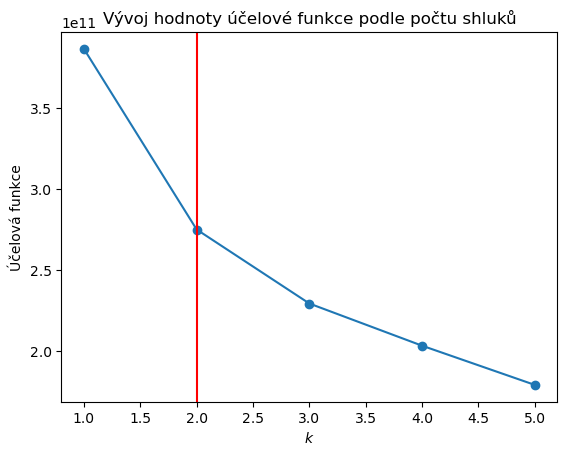

In [17]:
ix = np.zeros(5)
iy = np.zeros(5)
for i in range(ix.shape[0]):
    kmeans = KMeans(n_clusters=i+1, random_state = 1)
    kmeans.fit(df)
    iy[i] = kmeans.inertia_
    ix[i] = i+1

plt.title("Vývoj hodnoty účelové funkce podle počtu shluků")
plt.xlabel('$k$')
plt.ylabel('Účelová funkce')
plt.plot(ix, iy, 'o-')
plt.axvline(k, color='r')
plt.show()

## Aglomerativní hierarchické shlukování

* Matice záměn

In [18]:
Z = linkage(df, method="ward", metric="euclidean")

* Scikit implementace

In [38]:
d = 18000 # hyperparametr
agg = AgglomerativeClustering(distance_threshold=None, n_clusters=k, linkage='single', compute_distances=True).fit(df)

* Hierarchické shlukování má velmi rozdílné výsledky než algoritmus kmeans

In [20]:
print("Počet:", (agg.labels_ == kmeans_result.labels_).sum())
print("Procentuální shoda:", (agg.labels_ == kmeans_result.labels_).sum() / len(agg.labels_) * 100)

Počet: 1839
Procentuální shoda: 21.294580824455767


### Dendrogram

* Tam kde je vysokáý sloupec je velká vzdálenost mezi shluky, které se spojovali, proto jsem zvolil vhodnou výšku jako 24 000, protože tam je výška nejvýraznější

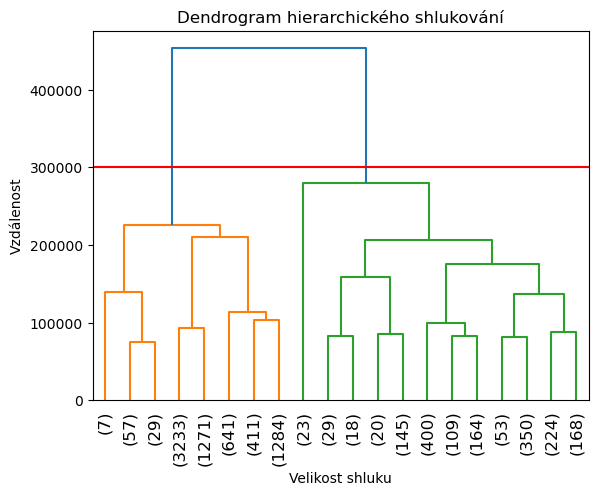

In [21]:
plt.title("Dendrogram hierarchického shlukování")
plt.xlabel("Velikost shluku")
plt.ylabel("Vzdálenost")

dendrogram(
    Z,
    truncate_mode="lastp",  # Zobraz jenom posledních p spojených shluků
    p=20,  # Nastavení tohto p
    leaf_rotation=90.,
    leaf_font_size=12.,
)
plt.axhline(d, color='r')
plt.show()

## Výběr nejlepšího shlukování

* Algoritmus kmeans mi rozdělil data na skupiny po 1839 a 6797, které pokládám za vypovídající, protože jsou v té menší skupině téměř ve všech sloupcích výrazně vyšší průměrné hodnoty (viz statistiky pod tímto textem).

In [22]:
df_copy = df.copy()

In [39]:
df_copy["kmeans"] = kmeans_result.labels_
df_copy["agg"] = agg.labels_

In [24]:
df_copy.describe()

,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE,kmeans,agg
count,8636.000000,8636.000000,8636.000000,8636.000000,8636.000000,8636.000000,8636.000000,8636.000000,8636.000000,8636.000000,8636.000000,8636.000000,8636.000000,8636.000000,8636.000000,8636.000000,8636.000000,8636.000000,8636.0
mean,1601.224893,0.895035,1025.433874,604.901438,420.843533,994.175523,0.496000,0.205909,0.368820,0.137604,3.313918,15.033233,4522.091030,1784.478099,864.304943,0.159304,11.534391,0.787054,0.0
std,2095.571300,0.207697,2167.107984,1684.307803,917.245182,2121.458303,0.401273,0.300054,0.398093,0.201791,6.912506,25.180468,3659.240379,2909.810090,2372.566350,0.296271,1.310984,0.409413,0.0
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,50.000000,0.049513,0.019163,0.000000,6.000000,0.000000,0.0
25%,148.095189,0.909091,43.367500,0.000000,0.000000,0.000000,0.083333,0.000000,0.000000,0.000000,0.000000,1.000000,1600.000000,418.559237,169.163545,0.000000,12.000000,1.000000,0.0
50%,916.855459,1.000000,375.405000,44.995000,94.785000,0.000000,0.500000,0.083333,0.166667,0.000000,0.000000,7.000000,3000.000000,896.675701,312.452292,0.000000,12.000000,1.000000,0.0
75%,2105.195853,1.000000,1145.980000,599.100000,484.147500,1132.385490,0.916667,0.333333,0.750000,0.250000,4.000000,18.000000,6500.000000,1951.142090,825.496463,0.166667,12.000000,1.000000,0.0
max,19043.138560,1.000000,49039.570000,40761.250000,22500.000000,47137.211760,1.000000,1.000000,1.000000,1.500000,123.000000,358.000000,30000.000000,50721.483360,76406.207520,1.000000,12.000000,1.000000,0.0


In [25]:
df_copy[df_copy["kmeans"] == 0].describe()

,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE,kmeans,agg
count,1839.000000,1839.000000,1839.000000,1839.000000,1839.000000,1839.000000,1839.000000,1839.000000,1839.000000,1839.000000,1839.000000,1839.000000,1839.000000,1839.000000,1839.000000,1839.000000,1839.000000,1839.0,1839.0
mean,3904.521491,0.945309,2427.202110,1589.736678,837.866710,2634.835773,0.564316,0.349820,0.412560,0.230328,6.706362,28.689505,9895.380394,4403.234365,1802.956599,0.151932,11.747689,0.0,0.0
std,3098.256284,0.147418,4076.306733,3234.538379,1657.929417,3736.631039,0.412816,0.367480,0.413937,0.262746,11.035886,42.112560,3471.784853,5135.390580,4151.202184,0.301613,0.945445,0.0,0.0
min,0.488050,0.090909,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1200.000000,31.845894,5.045387,0.000000,6.000000,0.0,0.0
25%,1130.014995,1.000000,102.915000,0.000000,0.000000,0.000000,0.083333,0.000000,0.000000,0.000000,0.000000,1.000000,7500.000000,1404.265482,361.692247,0.000000,12.000000,0.0,0.0
50%,3508.560867,1.000000,1023.290000,451.180000,192.950000,1209.369868,0.666667,0.181818,0.333333,0.166667,2.000000,12.000000,9200.000000,2543.550697,1040.283795,0.000000,12.000000,0.0,0.0
75%,5826.650811,1.000000,3256.155000,1936.255000,1056.245000,4096.108984,1.000000,0.666667,0.833333,0.416667,10.000000,39.000000,11500.000000,5694.238346,1867.921325,0.090909,12.000000,0.0,0.0
max,19043.138560,1.000000,49039.570000,40761.250000,22500.000000,47137.211760,1.000000,1.000000,1.000000,1.250000,123.000000,358.000000,30000.000000,50721.483360,76406.207520,1.000000,12.000000,0.0,0.0


In [26]:
df_copy[df_copy["kmeans"] == 1].describe()

,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE,kmeans,agg
count,6797.000000,6797.000000,6797.000000,6797.000000,6797.000000,6797.000000,6797.000000,6797.000000,6797.000000,6797.000000,6797.000000,6797.000000,6797.000000,6797.000000,6797.000000,6797.000000,6797.000000,6797.0,6797.0
mean,978.043718,0.881433,646.170702,338.443883,308.013516,550.277597,0.477516,0.166972,0.356986,0.112517,2.396057,11.338385,3068.290950,1075.945986,610.342843,0.161298,11.476681,1.0,0.0
std,1076.852891,0.219237,893.134122,664.488912,515.567946,1008.364576,0.396103,0.265992,0.392892,0.173527,4.880289,16.182476,1956.234944,1125.998686,1479.458370,0.294800,1.387934,0.0,0.0
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,50.000000,0.049513,0.019163,0.000000,6.000000,1.0,0.0
25%,95.853493,0.857143,35.800000,0.000000,0.000000,0.000000,0.083333,0.000000,0.000000,0.000000,0.000000,1.000000,1500.000000,347.227774,158.916575,0.000000,12.000000,1.0,0.0
50%,654.574445,1.000000,317.100000,0.000000,81.120000,0.000000,0.416667,0.000000,0.166667,0.000000,0.000000,7.000000,2500.000000,676.487532,248.140964,0.000000,12.000000,1.0,0.0
75%,1466.852542,1.000000,875.520000,400.000000,416.730000,730.506420,0.916667,0.250000,0.750000,0.166667,3.000000,14.000000,4000.000000,1379.683829,576.331228,0.166667,12.000000,1.0,0.0
max,5965.535557,1.000000,8591.310000,8053.950000,4313.220000,6718.127621,1.000000,1.000000,1.000000,1.500000,123.000000,232.000000,10000.000000,10893.778440,28483.254830,1.000000,12.000000,1.0,0.0


## Interpretace výsledků

* Uživatele kreditních karet bych rozdělil na dvě skupiny a to ty, kteří mají kreditní limit vyšší než 1200. Je pro ně více typická vyšší zůstatek na účtě a vyšší útraty.

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=62af5576-b435-40ad-9eb0-b24d592b1e67' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>